In [1]:
#import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import os
from sklearn.model_selection import train_test_split


import json
import numpy as np
import pandas as pd
from sklearn import preprocessing
import os
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
import matplotlib.image as mpimg
from  matplotlib import pyplot
import cv2
import random
from PIL import Image
from sklearn.utils import class_weight
import numpy
import codecs

In [2]:
!pip install xmltodict

You are using pip version 9.0.3, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [216]:
import xmltodict, json
landmark_annotations = os.listdir('tangier_lobster_images_for_landmarks_pts/')
import imgaug as ia
from imgaug import augmenters as iaa
import math

In [217]:
def load(path):
    """takes as input the path to a .pts and returns a list of 
    tuples of floats containing the points in in the form:
    [(x_0, y_0, z_0),
     (x_1, y_1, z_1),
    ...
     (x_n, y_n, z_n)]"""
    with codecs.open(path, 'r', encoding='utf-8') as f:
        rows = [rows.strip() for rows in f]
    
    """Use the curly braces to find the start and end of the point data""" 
    head = rows.index('{') + 1
    tail = rows.index('}')

    """Select the point data split into coordinates"""
    raw_points = rows[head:tail]
    coords_set = [point.split() for point in raw_points]

    """Convert entries from lists of strings to tuples of floats"""
    points = [tuple([float(point) for point in coords]) for coords in coords_set]
    return points

In [2]:
def process_image_keypoints(img,rectangle_points,bbox_coords):
    desired_size = 448

    old_size = img.shape

    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

    # new_size should be in (width, height) format

    im = cv2.resize(img, (new_size[1], new_size[0]))

    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,
        value=color)

    point_list = rectangle_points
    rects = []
    for a,b in point_list:
        a = a*ratio
        b = b*ratio
        rects.append([a+left,b+top])
    bbox_coordinates = []
    for a,b in bbox_coords:
        a = float(a)*ratio
        b = float(b)*ratio
        bbox_coordinates.append([a+left,b+top])
    return new_im,rects,bbox_coordinates

In [1]:
def process_image_keypoints_nobox(img):
    desired_size = 224

    old_size = img.shape

    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

    # new_size should be in (width, height) format

    im = cv2.resize(img, (new_size[1], new_size[0]))

    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,
        value=color)

    return new_im,[left,top,ratio]

In [254]:
for idx,i in enumerate(landmarks):
    if len(i.keypoints)!=16:
        print(idx,len(i.keypoints))
        print(image_names[idx])

In [253]:
count_correct = 0
count_wrong = 0
labels =  []
images = []
bb = []
bboxes = []
image_sizes = []
image_names = []
bb_sizes = []
landmarks =  []
for file in os.listdir("tangier_lobster_images_for_landmarks_pts/"):
    try:
        if file.endswith(".pts"):
                image_name = file.split("_imglab.pts")[0]
                path = 'tangier_lobster_images_for_landmarks/'+image_name
                bgr_img = cv2.imread(path)
                print(path)
                img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
                path = 'tangier_lobster_images_for_landmarks_pts/'+file
                points = load(path)
                print('tangier_lobster_for_landmarks_bboxes/'+file)
                with open('tangier_lobster_for_landmarks_bboxes/'+image_name.split(".")[0]+'.xml','r') as f:
                   text = f.read()
                   d = xmltodict.parse(text)
                obj = d['annotation']['object'][0] if isinstance(d['annotation']['object'],list) else d['annotation']['object']
                #print(obj)
                bbox = obj['bndbox']                
                bbox_coords = [(bbox['xmin'],bbox['ymin']),(bbox['xmax'],bbox['ymax'])]
                #bbox_coords = [[cx - (w/2.0),cy - (h/2.0)],[cx + (w/2.0),cy + (h/2.0)]]
                print(bbox_coords)
                
                img,rectange_points,bbox_coords = process_image_keypoints(img,points,bbox_coords)

                keypoints = []
                for x,y in rectange_points:
                        keypoints.append(ia.Keypoint(x=x, y=y))
                
                bbs = ia.BoundingBoxesOnImage([
                    ia.BoundingBox(x1=bbox_coords[0][0], y1=bbox_coords[0][1], x2=bbox_coords[1][0], y2=bbox_coords[1][1])
                ], shape=img.shape)
                
                images.append(img)
                landmarks.append(ia.KeypointsOnImage(keypoints, shape=img.shape))
                bboxes.append(bbs)
                image_names.append(file)
                #labels.append(obj['name'])
                #bb_sizes.append((w,h))
                #bboxes_rot.append([w,h,cx,cy,angle])
                image_sizes.append((float(d['annotation']['size']['width']),float(d['annotation']['size']['height'])))
                count_correct += 1
    except Exception as ex:
       print(ex)
       count_wrong += 1

tangier_lobster_images_for_landmarks/77_1.jpg
tangier_lobster_for_landmarks_bboxes/77_1.jpg_imglab.pts
[('1156', '945'), ('2381', '2579')]
tangier_lobster_images_for_landmarks/42_22.JPG
tangier_lobster_for_landmarks_bboxes/42_22.JPG_imglab.pts
[('221', '301'), ('3739', '2257')]
tangier_lobster_images_for_landmarks/61_11.JPG
tangier_lobster_for_landmarks_bboxes/61_11.JPG_imglab.pts
[('553', '645'), ('3342', '2130')]
tangier_lobster_images_for_landmarks/80_22.JPG
tangier_lobster_for_landmarks_bboxes/80_22.JPG_imglab.pts
[('165', '500'), ('3177', '2016')]
tangier_lobster_images_for_landmarks/69_22.JPG
tangier_lobster_for_landmarks_bboxes/69_22.JPG_imglab.pts
[('378', '318'), ('3454', '2179')]
tangier_lobster_images_for_landmarks/12_1.JPG
tangier_lobster_for_landmarks_bboxes/12_1.JPG_imglab.pts
[('1916', '1'), ('3801', '2888')]
tangier_lobster_images_for_landmarks/93_2.jpg
tangier_lobster_for_landmarks_bboxes/93_2.jpg_imglab.pts
[('1402', '733'), ('2741', '2330')]
tangier_lobster_images_fo

tangier_lobster_images_for_landmarks/69_1.jpg
tangier_lobster_for_landmarks_bboxes/69_1.jpg_imglab.pts
[('1577', '598'), ('2680', '2486')]
tangier_lobster_images_for_landmarks/59_2.jpg
tangier_lobster_for_landmarks_bboxes/59_2.jpg_imglab.pts
[('1126', '961'), ('2435', '2479')]
tangier_lobster_images_for_landmarks/21_11.JPG
tangier_lobster_for_landmarks_bboxes/21_11.JPG_imglab.pts
[('192', '239'), ('3359', '2189')]
tangier_lobster_images_for_landmarks/110_22.JPG
tangier_lobster_for_landmarks_bboxes/110_22.JPG_imglab.pts
[('232', '533'), ('3223', '2200')]
tangier_lobster_images_for_landmarks/14_44.JPG
tangier_lobster_for_landmarks_bboxes/14_44.JPG_imglab.pts
[('368', '363'), ('3195', '1948')]
tangier_lobster_images_for_landmarks/59_1.jpg
tangier_lobster_for_landmarks_bboxes/59_1.jpg_imglab.pts
[('1153', '793'), ('2368', '2654')]
tangier_lobster_images_for_landmarks/17_11.JPG
tangier_lobster_for_landmarks_bboxes/17_11.JPG_imglab.pts
[('427', '289'), ('3239', '1851')]
tangier_lobster_image

tangier_lobster_images_for_landmarks/40_1.JPG
tangier_lobster_for_landmarks_bboxes/40_1.JPG_imglab.pts
[('1888', '406'), ('3984', '3632')]
tangier_lobster_images_for_landmarks/44_1.JPG
tangier_lobster_for_landmarks_bboxes/44_1.JPG_imglab.pts
[('2132', '475'), ('4097', '3714')]
tangier_lobster_images_for_landmarks/55_1.jpg
tangier_lobster_for_landmarks_bboxes/55_1.jpg_imglab.pts
[('1180', '730'), ('2392', '2430')]
tangier_lobster_images_for_landmarks/103_11.JPG
tangier_lobster_for_landmarks_bboxes/103_11.JPG_imglab.pts
[('311', '582'), ('3229', '2064')]
tangier_lobster_images_for_landmarks/111_2.jpg
tangier_lobster_for_landmarks_bboxes/111_2.jpg_imglab.pts
[('1317', '466'), ('2453', '2242')]
tangier_lobster_images_for_landmarks/14_11.JPG
tangier_lobster_for_landmarks_bboxes/14_11.JPG_imglab.pts
[('253', '610'), ('3318', '2207')]
tangier_lobster_images_for_landmarks/106_2.jpg
tangier_lobster_for_landmarks_bboxes/106_2.jpg_imglab.pts
[('1584', '360'), ('2550', '2269')]
tangier_lobster_ima

tangier_lobster_images_for_landmarks/109_22.JPG
tangier_lobster_for_landmarks_bboxes/109_22.JPG_imglab.pts
[('175', '437'), ('3133', '1837')]
tangier_lobster_images_for_landmarks/42_1.JPG
tangier_lobster_for_landmarks_bboxes/42_1.JPG_imglab.pts
[('1719', '388'), ('4040', '3675')]
tangier_lobster_images_for_landmarks/68_2.jpg
tangier_lobster_for_landmarks_bboxes/68_2.jpg_imglab.pts
[('1502', '694'), ('2568', '2412')]
tangier_lobster_images_for_landmarks/44_44.JPG
tangier_lobster_for_landmarks_bboxes/44_44.JPG_imglab.pts
[('286', '124'), ('3709', '2513')]
tangier_lobster_images_for_landmarks/53_44.JPG
tangier_lobster_for_landmarks_bboxes/53_44.JPG_imglab.pts
[('292', '689'), ('3242', '2245')]
tangier_lobster_images_for_landmarks/21_22.JPG
tangier_lobster_for_landmarks_bboxes/21_22.JPG_imglab.pts
[('318', '110'), ('3339', '2389')]
tangier_lobster_images_for_landmarks/92_1.jpg
tangier_lobster_for_landmarks_bboxes/92_1.jpg_imglab.pts
[('1314', '615'), ('2590', '2263')]
tangier_lobster_image

tangier_lobster_images_for_landmarks/98_22.JPG
tangier_lobster_for_landmarks_bboxes/98_22.JPG_imglab.pts
[('86', '540'), ('3117', '2225')]
tangier_lobster_images_for_landmarks/32_1.JPG
tangier_lobster_for_landmarks_bboxes/32_1.JPG_imglab.pts
[('2119', '462'), ('4036', '3445')]
tangier_lobster_images_for_landmarks/27_22.JPG
tangier_lobster_for_landmarks_bboxes/27_22.JPG_imglab.pts
[('318', '454'), ('3371', '2495')]
tangier_lobster_images_for_landmarks/15_1.JPG
tangier_lobster_for_landmarks_bboxes/15_1.JPG_imglab.pts
[('1997', '210'), ('4119', '3175')]
tangier_lobster_images_for_landmarks/14_2.JPG
tangier_lobster_for_landmarks_bboxes/14_2.JPG_imglab.pts
[('2166', '249'), ('4132', '3380')]
tangier_lobster_images_for_landmarks/30_22.JPG
tangier_lobster_for_landmarks_bboxes/30_22.JPG_imglab.pts
[('171', '233'), ('3206', '1957')]
tangier_lobster_images_for_landmarks/63_22.JPG
tangier_lobster_for_landmarks_bboxes/63_22.JPG_imglab.pts
[('698', '707'), ('3124', '2454')]
tangier_lobster_images_f

tangier_lobster_images_for_landmarks/8_11.JPG
tangier_lobster_for_landmarks_bboxes/8_11.JPG_imglab.pts
[('424', '471'), ('3201', '2001')]
tangier_lobster_images_for_landmarks/15_22.JPG
tangier_lobster_for_landmarks_bboxes/15_22.JPG_imglab.pts
[('321', '348'), ('3298', '2092')]
tangier_lobster_images_for_landmarks/68_1.jpg
tangier_lobster_for_landmarks_bboxes/68_1.jpg_imglab.pts
[('1356', '694'), ('2616', '2412')]
tangier_lobster_images_for_landmarks/96_33.JPG
tangier_lobster_for_landmarks_bboxes/96_33.JPG_imglab.pts
[('862', '609'), ('3296', '2652')]
tangier_lobster_images_for_landmarks/59_33.JPG
tangier_lobster_for_landmarks_bboxes/59_33.JPG_imglab.pts
[('459', '366'), ('3183', '2445')]
tangier_lobster_images_for_landmarks/93_11.JPG
tangier_lobster_for_landmarks_bboxes/93_11.JPG_imglab.pts
[('708', '71'), ('3518', '2062')]
tangier_lobster_images_for_landmarks/17_1.JPG
tangier_lobster_for_landmarks_bboxes/17_1.JPG_imglab.pts
[('2193', '358'), ('4006', '3249')]
tangier_lobster_images_fo

tangier_lobster_images_for_landmarks/62_1.jpg
tangier_lobster_for_landmarks_bboxes/62_1.jpg_imglab.pts
[('1441', '676'), ('2650', '2624')]
tangier_lobster_images_for_landmarks/76_1.jpg
tangier_lobster_for_landmarks_bboxes/76_1.jpg_imglab.pts
[('950', '782'), ('2329', '2376')]
tangier_lobster_images_for_landmarks/85_33.JPG
tangier_lobster_for_landmarks_bboxes/85_33.JPG_imglab.pts
[('912', '359'), ('2606', '2744')]
tangier_lobster_images_for_landmarks/49_1.JPG
tangier_lobster_for_landmarks_bboxes/49_1.JPG_imglab.pts
[('1875', '475'), ('3827', '3632')]
tangier_lobster_images_for_landmarks/47_33.JPG
tangier_lobster_for_landmarks_bboxes/47_33.JPG_imglab.pts
[('336', '368'), ('3501', '2413')]
tangier_lobster_images_for_landmarks/8_33.JPG
tangier_lobster_for_landmarks_bboxes/8_33.JPG_imglab.pts
[('142', '377'), ('3456', '2177')]
tangier_lobster_images_for_landmarks/20_1.JPG
tangier_lobster_for_landmarks_bboxes/20_1.JPG_imglab.pts
[('1828', '1'), ('4093', '3167')]
tangier_lobster_images_for_la

tangier_lobster_images_for_landmarks/15_33.JPG
tangier_lobster_for_landmarks_bboxes/15_33.JPG_imglab.pts
[('271', '318'), ('3374', '2166')]
tangier_lobster_images_for_landmarks/94_22.JPG
tangier_lobster_for_landmarks_bboxes/94_22.JPG_imglab.pts
[('411', '516'), ('3147', '2258')]
tangier_lobster_images_for_landmarks/7_1.JPG
tangier_lobster_for_landmarks_bboxes/7_1.JPG_imglab.pts
[('1952', '1'), ('3932', '3093')]
tangier_lobster_images_for_landmarks/70_1.jpg
tangier_lobster_for_landmarks_bboxes/70_1.jpg_imglab.pts
[('925', '773'), ('2556', '2315')]
tangier_lobster_images_for_landmarks/86_1.jpg
tangier_lobster_for_landmarks_bboxes/86_1.jpg_imglab.pts
[('1243', '664'), ('2337', '2461')]
tangier_lobster_images_for_landmarks/79_11.JPG
tangier_lobster_for_landmarks_bboxes/79_11.JPG_imglab.pts
[('475', '364'), ('3109', '2025')]
tangier_lobster_images_for_landmarks/1_11.JPG
tangier_lobster_for_landmarks_bboxes/1_11.JPG_imglab.pts
[('327', '548'), ('3039', '2404')]
tangier_lobster_images_for_lan

tangier_lobster_images_for_landmarks/74_1.jpg
tangier_lobster_for_landmarks_bboxes/74_1.jpg_imglab.pts
[('1407', '585'), ('2619', '2455')]
tangier_lobster_images_for_landmarks/90_22.JPG
tangier_lobster_for_landmarks_bboxes/90_22.JPG_imglab.pts
[('345', '379'), ('3160', '2249')]
tangier_lobster_images_for_landmarks/28_22.JPG
tangier_lobster_for_landmarks_bboxes/28_22.JPG_imglab.pts
[('627', '74'), ('2948', '2289')]
tangier_lobster_images_for_landmarks/104_2.jpg
tangier_lobster_for_landmarks_bboxes/104_2.jpg_imglab.pts
[('1522', '431'), ('2465', '2343')]
tangier_lobster_images_for_landmarks/90_1.jpg
tangier_lobster_for_landmarks_bboxes/90_1.jpg_imglab.pts
[('1324', '718'), ('2490', '2412')]
tangier_lobster_images_for_landmarks/60_22.JPG
tangier_lobster_for_landmarks_bboxes/60_22.JPG_imglab.pts
[('98', '439'), ('3324', '2168')]
tangier_lobster_images_for_landmarks/90_11.JPG
tangier_lobster_for_landmarks_bboxes/90_11.JPG_imglab.pts
[('554', '503'), ('3335', '2112')]
tangier_lobster_images_

tangier_lobster_images_for_landmarks/104_1.jpg
tangier_lobster_for_landmarks_bboxes/104_1.jpg_imglab.pts
[('1466', '453'), ('2478', '2325')]
tangier_lobster_images_for_landmarks/77_33.JPG
tangier_lobster_for_landmarks_bboxes/77_33.JPG_imglab.pts
[('299', '519'), ('3265', '2477')]
tangier_lobster_images_for_landmarks/3_22.JPG
tangier_lobster_for_landmarks_bboxes/3_22.JPG_imglab.pts
[('262', '257'), ('3359', '2610')]
tangier_lobster_images_for_landmarks/72_2.jpg
tangier_lobster_for_landmarks_bboxes/72_2.jpg_imglab.pts
[('1441', '791'), ('2684', '2661')]
tangier_lobster_images_for_landmarks/24_11.JPG
tangier_lobster_for_landmarks_bboxes/24_11.JPG_imglab.pts
[('412', '680'), ('3212', '1824')]
tangier_lobster_images_for_landmarks/13_2.JPG
tangier_lobster_for_landmarks_bboxes/13_2.JPG_imglab.pts
[('1841', '1'), ('3753', '2736')]
tangier_lobster_images_for_landmarks/56_44.JPG
tangier_lobster_for_landmarks_bboxes/56_44.JPG_imglab.pts
[('312', '233'), ('3633', '2768')]
tangier_lobster_images_fo

In [293]:
idx = idx + 1
print(idx)
pt1 = (int(bboxes[idx].bounding_boxes[0].x1),int(bboxes[idx].bounding_boxes[0].y1))
pt2 = (int(bboxes[idx].bounding_boxes[0].x2),int(bboxes[idx].bounding_boxes[0].y2))
print(pt1)
print(pt2)
img = cv2.rectangle(images[idx],pt1,pt2,(0,255,255),thickness=2)

bbs =list(np.array(landmarks))
for obj in bbs[idx].keypoints:
    img = cv2.circle(images[idx],(int(obj.x),int(obj.y)), 1, (0,0,255), -1)    
pil_im = Image.fromarray(img)
plt.figure(figsize=(15,15))
plt.imshow(pil_im)
print(image_names[idx])

50
(13, 132)
(373, 286)
109_33.JPG_imglab.pts


In [306]:
sometimes = lambda aug: iaa.Sometimes(0.5, aug)
seq = iaa.Sequential(
    [
        # apply the following augmenters to most images
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        iaa.Flipud(0.5), # vertically flip 50% of all images
        # crop images by -5% to 10% of their height/width
        #sometimes(iaa.CropAndPad(
        #    percent=(-0.05, 0.1),
        #    pad_mode=ia.ALL,
        #    pad_cval=(0, 255)
        #)),
        sometimes(iaa.Affine(
            #scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, # translate by -20 to +20 percent (per axis)
            rotate=(-45, 45), # rotate by -45 to +45 degrees
            #shear=(-16, 16), # shear by -16 to +16 degrees
            order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            cval=(0, 255), # if mode is constant, use a cval between 0 and 255
            mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        )),
        # execute 0 to 5 of the following (less important) augmenters per image
        # don't execute all of them, as that would often be way too strong
        iaa.SomeOf((0, 5),
            [
                #sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                #iaa.OneOf([
                #    iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
                #    iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
                #    iaa.MedianBlur(k=(3, 11)), # blur image using local medians with kernel sizes between 2 and 7
                #]),
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
                #iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                # search either for all edges or for directed edges,
                # blend the result with the original image using a blobby mask
                #iaa.SimplexNoiseAlpha(iaa.OneOf([
                #    iaa.EdgeDetect(alpha=(0.5, 1.0)),
                #    iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                #])),
                #iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
                #iaa.OneOf([
                #    iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
                #    iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                #]),
                #iaa.Invert(0.05, per_channel=True), # invert color channels
                iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                #iaa.AddToHueAndSaturation((-10, 20)), # change hue and saturation
                # either change the brightness of the whole image (sometimes
                # per channel) or change the brightness of subareas
                iaa.OneOf([
                    #iaa.Multiply((0.5, 1.5), per_channel=0.5),
                    #iaa.FrequencyNoiseAlpha(
                    #    exponent=(-4, 0),
                    #    first=iaa.Multiply((0.5, 1.5), per_channel=True),
                    #    second=iaa.ContrastNormalization((0.5, 2.0))
                    #)
                ]),
                iaa.ContrastNormalization((0.9, 1.10), per_channel=0.5), # improve or worsen the contrast
                #iaa.Grayscale(alpha=(0.0, 1.0)),
                #sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                #sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
                #sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
            ],
            random_order=True
        )
    ],
    random_order=True
)

In [295]:
# landmarks = list(np.array(landmarks)[indexes])
# bboxes = list(np.array(bboxes)[indexes])
# labels =  list(np.array(labels)[indexes])
# images = list(np.array(images)[indexes])
# image_sizes = list(np.array(image_sizes)[indexes])

In [296]:
# import seaborn as sns
# import numpy as np
# from scipy.stats import itemfreq
# itemfreq(labels)

In [297]:
# num_labels = len(np.unique(list(labels)))
# from sklearn import preprocessing
# le = preprocessing.LabelEncoder()
# le.fit(list(labels))
# le_labels = le.transform(labels)
# one = preprocessing.OneHotEncoder()
# one.fit(list(le_labels.reshape(-1,1)))
# one_labels = one.transform(le_labels.reshape(-1,1))
# numpy.save('classes.npy', le.classes_)

In [298]:
def augment_images(images,landmarks,bboxes,image_sizes,times):
    all_landmarks = []
    all_bboxes = []
    all_images = list(images)
    all_image_sizes = list(image_sizes)

    for landmark in landmarks:
            outputs = []
            for obj in landmark.keypoints:
                outputs.append(obj.x)
                outputs.append(obj.y)
            all_landmarks.append(np.array(outputs))
    for bbs in bboxes:
            all_bboxes.append(np.array([bbs.bounding_boxes[0].x1,bbs.bounding_boxes[0].y1,bbs.bounding_boxes[0].x2,bbs.bounding_boxes[0].y2]))

    for i in range(times):
        seq_det = seq.to_deterministic()
        image_aug = seq_det.augment_images(images)
        bbs_aug = seq_det.augment_keypoints(landmarks)
        for bbs in bbs_aug:
            outputs = []
            for obj in bbs.keypoints:
                outputs.append(obj.x)
                outputs.append(obj.y)
            all_landmarks.append(np.array(outputs))
        bbs_aug = seq_det.augment_bounding_boxes(bboxes)
        for bbs in bbs_aug:
            all_bboxes.append(np.array([bbs.bounding_boxes[0].x1,bbs.bounding_boxes[0].y1,bbs.bounding_boxes[0].x2,bbs.bounding_boxes[0].y2]))

        all_images = all_images + list(image_aug)
        all_image_sizes = all_image_sizes + list(image_sizes)
    return all_images,all_landmarks,all_bboxes,all_image_sizes

In [308]:
# len(all_images)

In [300]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5,shuffle=False,random_state=100)
test_cvscores = []
validation_cvscores = []
fusion_model_info = []
kfold_data = []

i = 0
for train, test in kf.split(images):
    i = i + 1
    print(i)
    all_images,all_landmarks,all_bboxes,all_image_sizes = augment_images(np.array(images)[train],np.array(landmarks)[train],np.array(bboxes)[train],np.array(image_sizes)[train],2)
    test_bboxes = []
    test_landmarks = []
    
    for bbs in list(np.array(bboxes)[test]):
        test_bboxes.append(np.array([bbs.bounding_boxes[0].x1,bbs.bounding_boxes[0].y1,bbs.bounding_boxes[0].x2,bbs.bounding_boxes[0].y2]))
    
    for bbs in list(np.array(landmarks)[test]):
            outputs = []
            for obj in bbs.keypoints:
                outputs.append(obj.x)
                outputs.append(obj.y)
            test_landmarks.append(np.array(outputs))
    kfold_data.append([all_images,all_landmarks,all_bboxes,all_image_sizes,np.array(images)[test],test_landmarks,test_bboxes,np.array(image_sizes)[test]])

1
2
3
4
5


In [301]:
with open('data-localize-landmarks-tangier0.pckl','wb') as file:
    pickle.dump(kfold_data[0],file)
with open('data-localize-landmarks-tangier1.pckl','wb') as file:
    pickle.dump(kfold_data[1],file)
with open('data-localize-landmarks-tangier2.pckl','wb') as file:
    pickle.dump(kfold_data[2],file)
with open('data-localize-landmarks-tangier3.pckl','wb') as file:
    pickle.dump(kfold_data[3],file)
with open('data-localize-landmarks-tangier4.pckl','wb') as file:
    pickle.dump(kfold_data[4],file)

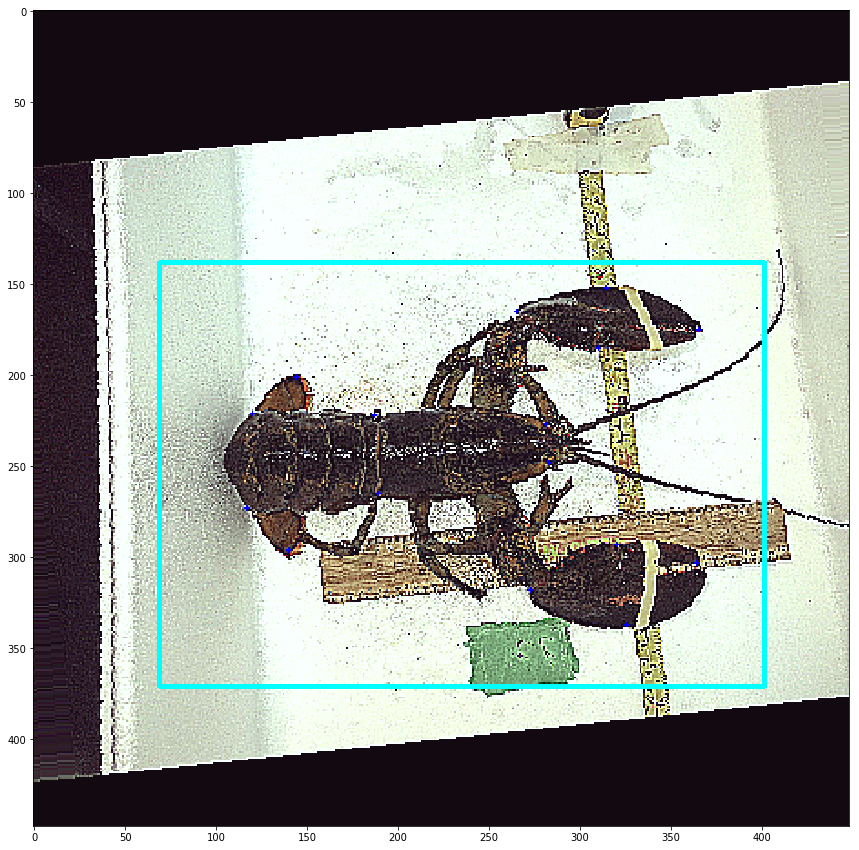

In [305]:
idx = 200+378
tuples = []
for i in range(16):
    tuples.append((all_landmarks[idx][i*2],all_landmarks[idx][i*2+1]))
for i in range(16):
    img = cv2.circle(all_images[idx],(int(tuples[i][0]),int(tuples[i][1])), 1, (0,0,255), -1)
    
pt1 = (int(all_bboxes[idx][0]),int(all_bboxes[idx][1]))
pt2 = (int(all_bboxes[idx][2]),int(all_bboxes[idx][3]))
img = cv2.rectangle(all_images[idx],pt1,pt2,(0,255,255),thickness=2)
pil_im = Image.fromarray(img)
plt.figure(figsize=(15,15))
plt.imshow(pil_im)

IndexError: index 4 is out of bounds for axis 0 with size 4

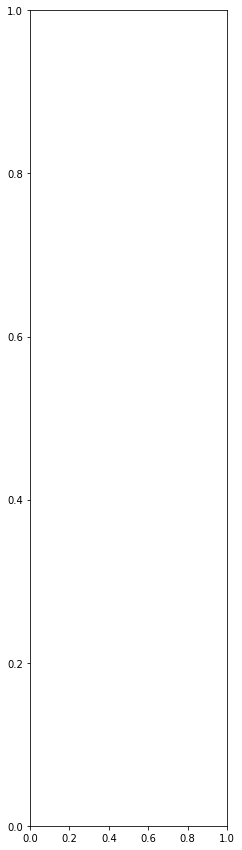

In [63]:
fig, ax = plt.subplots(figsize=(12,15))



plt.subplot(1, 3, 1)
idx = 381
point_list = []
#for keypoint in all_bboxes[idx].keypoints:
#    point_list.append([keypoint.x,keypoint.y])

point_list = [[all_bboxes[idx][0],all_bboxes[idx][1]],[all_bboxes[idx][2],all_bboxes[idx][3]],
[all_bboxes[idx][4],all_bboxes[idx][5]],[all_bboxes[idx][6],all_bboxes[idx][7]]]

pts = np.array(point_list)
pts = pts.reshape((-1,1,2))
img = cv2.polylines(all_images[idx],np.int32([pts]),thickness=2,color=(0,255,255),isClosed=True)
pil_im = Image.fromarray(img)
plt.imshow(pil_im)
plt.xticks([])
plt.yticks([])

plt.subplot(1, 3, 2)
idx = 786
point_list = []
#for keypoint in all_bboxes[idx].keypoints:
#    point_list.append([keypoint.x,keypoint.y])

point_list = [[all_bboxes[idx][0],all_bboxes[idx][1]],[all_bboxes[idx][2],all_bboxes[idx][3]],
[all_bboxes[idx][4],all_bboxes[idx][5]],[all_bboxes[idx][6],all_bboxes[idx][7]]]

pts = np.array(point_list)
pts = pts.reshape((-1,1,2))
img = cv2.polylines(all_images[idx],np.int32([pts]),thickness=2,color=(0,255,255),isClosed=True)
pil_im = Image.fromarray(img)
plt.imshow(pil_im)
plt.xticks([])
plt.yticks([])

plt.subplot(1, 3, 3)
idx = 1014
point_list = []
#for keypoint in all_bboxes[idx].keypoints:
#    point_list.append([keypoint.x,keypoint.y])

point_list = [[all_bboxes[idx][0],all_bboxes[idx][1]],[all_bboxes[idx][2],all_bboxes[idx][3]],
[all_bboxes[idx][4],all_bboxes[idx][5]],[all_bboxes[idx][6],all_bboxes[idx][7]]]

pts = np.array(point_list)
pts = pts.reshape((-1,1,2))
img = cv2.polylines(all_images[idx],np.int32([pts]),thickness=2,color=(0,255,255),isClosed=True)
pil_im = Image.fromarray(img)
plt.imshow(pil_im)
plt.xticks([])
plt.yticks([])

plt.savefig('rotated_bounding_boxes.jpg')
plt.show()

In [174]:
i 

72

In [256]:
bbs.keypoints[0]

Keypoint(x=187.75761159, y=208.26463522)